In [ ]:
import sys
sys.path.append("PATH_TO_SRC_DIR") # Replace with the actual path to your source directory

# Enable hot autoreload
%load_ext autoreload
%autoreload 2

In [13]:
import pickle
import numpy as np
from sklearn.metrics import roc_curve
import torch
from typing import Sequence
from collections import defaultdict
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, LlamaForCausalLM
from utils import compute_perplexity, ratio_auc, min_k_prob
import zlib
from tqdm import tqdm

np.random.seed(42)

In [ ]:
OG_NON_MEMBER_PATH = "SOME_DATA_DIR/non_members.pickle"
OG_CANARY_PATH = "SOME_DATA_DIR/members.pickle"

LLAMA_TOKENIZER_PATH = "SOME_DATA_DIR/Llama-2-7b-hf/"
LLAMA_MODEL_PATH = "SOME_DATA_DIR/Llama-2-7b-hf/"

TARGET_MODEL = "EleutherAI/gpt-neo-1.3B"

In [4]:
llama_device = "cuda:1"
llama_tokenizer = LlamaTokenizer.from_pretrained(LLAMA_TOKENIZER_PATH, torch_dtype=torch.float16)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_model = LlamaForCausalLM.from_pretrained(LLAMA_MODEL_PATH).to(llama_device)

target_tokenizer = AutoTokenizer.from_pretrained(TARGET_MODEL)
target_tokenizer.pad_token = target_tokenizer.eos_token
target_device = "cuda:0"

Loading checkpoint shards: 100%|██████████| 7/7 [01:45<00:00, 15.13s/it]
/home/matthieu/miniconda3/envs/canary/lib/python3.9/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Let's get the canary text
with open(OG_CANARY_PATH, 'rb') as f:
    og_canaries = pickle.load(f)
    
og_canary_texts = [target_tokenizer.decode(og_canary) for og_canary in og_canaries]
og_canary_texts_lower = [x.lower() for x in og_canary_texts]

# and the non member text
with open(OG_NON_MEMBER_PATH, 'rb') as f:
    non_members = pickle.load(f)

non_member_texts = [target_tokenizer.decode(non_member) for non_member in non_members]
non_member_texts_lower = [x.lower() for x in non_member_texts]

What do we need for the AUC? 

So that's just using the croissant_T loss of the reference canary. 

And using the loss of the same croissant_T model on the non-members. 

In [6]:
def roc_auc(members: Sequence[float], non_members: Sequence[float]):
    y = []
    y_true = []

    y.extend(members)
    y.extend(non_members)

    y_true.extend([0] * len(members))
    y_true.extend([1] * len(non_members))

    fpr, tpr, _ = roc_curve(y_true, y)

    return fpr, tpr

In [7]:
def tpr_at_fpr(members, non_members, target_fpr):
    fpr, tpr = roc_auc(members, non_members)

    index = np.abs(fpr - target_fpr).argmin()
    return tpr[index]

In [8]:
def get_auc_with_bootstrapping(ratio_members, ratio_non_members, k=25):
    all_aucs = list()
    for _ in range(k):
        subset_members = np.random.choice(ratio_members, len(ratio_members))
        subset_non_members = np.random.choice(ratio_non_members, len(ratio_non_members))
        auc = ratio_auc(members=subset_members, non_members=subset_non_members)
        all_aucs.append(auc)
    return np.array(all_aucs)

In [9]:
def ppl_from_text(texts, model, tokenizer, device):
    tokens = tokenizer.batch_encode_plus(texts, return_tensors="pt", padding="longest").to(device)
    ppl = compute_perplexity(
        model,
        tokens.input_ids[:, 1:],
        tokens.attention_mask[:, 1:],
        ignore_prefix=None
    )

    return ppl

In [ ]:
ngrams = (2, 5, 10,)
BASE_PATH = "SOME_DATA_DIR/model_checkpoints/EleutherAI_gpt-neo-1.3B_checkpoints/EleutherAI_gpt-neo-1.3B_gptneo1B_near_duplicates_kendall_dist_0{kendall}_ngram_{ngram}_lr2e5"

In [15]:
ngram_to_kendal_vals = {
    2: [1, 2, 3, 4, 5, 6, 7, 8, 9],
    5: [1, 2, 3, 4, 5, 6, 7, 8, 9],
    10: [2, 3, 4, 5, 6, 7, 8],
}

In [16]:
ngram_aucs = defaultdict(dict)

for ngram in ngrams:
    kendall_values = ngram_to_kendal_vals[ngram]

    for kendall in tqdm(kendall_values):
        
        model_path = BASE_PATH.format(kendall=kendall, ngram=ngram)

        score_members = {}
        score_non_members = {}
        
        target_model = AutoModelForCausalLM.from_pretrained(model_path).to(target_device)

        # first: non members
        print("Running on non members...")
        non_member_target_ppl = ppl_from_text(non_member_texts, target_model, target_tokenizer, target_device)
        non_member_llama_ppl = ppl_from_text(non_member_texts, llama_model, llama_tokenizer, llama_device)
        non_member_lower_target_ppl = ppl_from_text(non_member_texts_lower, target_model, target_tokenizer, target_device)

        target_tokens_non_members = target_tokenizer.batch_encode_plus(non_member_texts, return_tensors="pt", padding="longest").to(target_device)
        non_member_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in non_member_texts]
            
        score_non_members["ratio"] = non_member_target_ppl / non_member_llama_ppl
        score_non_members["loss"] = non_member_target_ppl
        score_non_members["lowercase"] = non_member_target_ppl / non_member_lower_target_ppl
        score_non_members["minkprob"] = -min_k_prob(target_model, target_tokens_non_members.input_ids, target_tokens_non_members.attention_mask)
        score_non_members["zlib"] = np.log(non_member_target_ppl) / non_member_zlib_entropy

        # now: members
        print("Running on canaries...")
        og_canary_target_ppl = ppl_from_text(og_canary_texts, target_model, target_tokenizer, target_device)
        og_canary_llama_ppl = ppl_from_text(og_canary_texts, llama_model, llama_tokenizer, llama_device)
        og_canary_lower_target_ppl = ppl_from_text(og_canary_texts_lower, target_model, target_tokenizer, target_device)

        target_tokens_og_canary = target_tokenizer.batch_encode_plus(og_canary_texts, return_tensors="pt", padding="longest").to(target_device)
        og_canary_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in og_canary_texts]

        score_members["ratio"] = og_canary_target_ppl / og_canary_llama_ppl
        score_members["loss"] = og_canary_target_ppl
        score_members["lowercase"] = og_canary_target_ppl / og_canary_lower_target_ppl
        score_members["minkprob"] = -min_k_prob(target_model, target_tokens_og_canary.input_ids, target_tokens_og_canary.attention_mask)
        score_members["zlib"] = np.log(og_canary_target_ppl) / og_canary_zlib_entropy

        for mia in score_members:
            aucs = get_auc_with_bootstrapping(ratio_members=score_members[mia], ratio_non_members=score_non_members[mia])
            tpr_at = tpr_at_fpr(score_members[mia], score_non_members[mia], target_fpr=0.1)
            print(f"ngram={ngram}, kendall={kendall}, MIA={mia}, AUC = {np.mean(aucs):.2f} ± {np.std(aucs):.2f}, TPR @ 0.1 FPR = {tpr_at:.2f}")
            ngram_aucs[f"ngram{ngram}_kendall{kendall}"][mia] = aucs
            
        print('-----')

  0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.84s/it]


Running on non members...
Running on canaries...


 11%|█         | 1/9 [01:03<08:31, 63.96s/it]

ngram=2, kendall=1, MIA=ratio, AUC = 0.93 ± 0.02, TPR @ 0.1 FPR = 0.79
ngram=2, kendall=1, MIA=loss, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.72
ngram=2, kendall=1, MIA=lowercase, AUC = 0.70 ± 0.04, TPR @ 0.1 FPR = 0.28
ngram=2, kendall=1, MIA=minkprob, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.73
ngram=2, kendall=1, MIA=zlib, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.65
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]


Running on non members...
Running on canaries...


 22%|██▏       | 2/9 [02:10<07:37, 65.43s/it]

ngram=2, kendall=2, MIA=ratio, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.75
ngram=2, kendall=2, MIA=loss, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.62
ngram=2, kendall=2, MIA=lowercase, AUC = 0.67 ± 0.04, TPR @ 0.1 FPR = 0.28
ngram=2, kendall=2, MIA=minkprob, AUC = 0.87 ± 0.03, TPR @ 0.1 FPR = 0.68
ngram=2, kendall=2, MIA=zlib, AUC = 0.80 ± 0.04, TPR @ 0.1 FPR = 0.56
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]


Running on non members...
Running on canaries...


 33%|███▎      | 3/9 [03:08<06:12, 62.04s/it]

ngram=2, kendall=3, MIA=ratio, AUC = 0.86 ± 0.02, TPR @ 0.1 FPR = 0.61
ngram=2, kendall=3, MIA=loss, AUC = 0.79 ± 0.03, TPR @ 0.1 FPR = 0.50
ngram=2, kendall=3, MIA=lowercase, AUC = 0.64 ± 0.03, TPR @ 0.1 FPR = 0.25
ngram=2, kendall=3, MIA=minkprob, AUC = 0.82 ± 0.03, TPR @ 0.1 FPR = 0.42
ngram=2, kendall=3, MIA=zlib, AUC = 0.76 ± 0.04, TPR @ 0.1 FPR = 0.45
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Running on non members...
Running on canaries...


 44%|████▍     | 4/9 [04:01<04:52, 58.45s/it]

ngram=2, kendall=4, MIA=ratio, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.51
ngram=2, kendall=4, MIA=loss, AUC = 0.75 ± 0.03, TPR @ 0.1 FPR = 0.44
ngram=2, kendall=4, MIA=lowercase, AUC = 0.62 ± 0.04, TPR @ 0.1 FPR = 0.19
ngram=2, kendall=4, MIA=minkprob, AUC = 0.79 ± 0.04, TPR @ 0.1 FPR = 0.38
ngram=2, kendall=4, MIA=zlib, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.41
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.84s/it]


Running on non members...
Running on canaries...


 56%|█████▌    | 5/9 [04:56<03:49, 57.35s/it]

ngram=2, kendall=5, MIA=ratio, AUC = 0.83 ± 0.02, TPR @ 0.1 FPR = 0.57
ngram=2, kendall=5, MIA=loss, AUC = 0.77 ± 0.04, TPR @ 0.1 FPR = 0.43
ngram=2, kendall=5, MIA=lowercase, AUC = 0.61 ± 0.04, TPR @ 0.1 FPR = 0.22
ngram=2, kendall=5, MIA=minkprob, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.41
ngram=2, kendall=5, MIA=zlib, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.38
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.90s/it]


Running on non members...
Running on canaries...


 67%|██████▋   | 6/9 [05:57<02:55, 58.57s/it]

ngram=2, kendall=6, MIA=ratio, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.52
ngram=2, kendall=6, MIA=loss, AUC = 0.74 ± 0.04, TPR @ 0.1 FPR = 0.40
ngram=2, kendall=6, MIA=lowercase, AUC = 0.60 ± 0.04, TPR @ 0.1 FPR = 0.22
ngram=2, kendall=6, MIA=minkprob, AUC = 0.78 ± 0.04, TPR @ 0.1 FPR = 0.37
ngram=2, kendall=6, MIA=zlib, AUC = 0.71 ± 0.05, TPR @ 0.1 FPR = 0.40
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]


Running on non members...
Running on canaries...


 78%|███████▊  | 7/9 [07:01<02:00, 60.28s/it]

ngram=2, kendall=7, MIA=ratio, AUC = 0.82 ± 0.03, TPR @ 0.1 FPR = 0.60
ngram=2, kendall=7, MIA=loss, AUC = 0.76 ± 0.03, TPR @ 0.1 FPR = 0.46
ngram=2, kendall=7, MIA=lowercase, AUC = 0.61 ± 0.04, TPR @ 0.1 FPR = 0.21
ngram=2, kendall=7, MIA=minkprob, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.39
ngram=2, kendall=7, MIA=zlib, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.38
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]


Running on non members...
Running on canaries...


 89%|████████▉ | 8/9 [08:01<01:00, 60.27s/it]

ngram=2, kendall=8, MIA=ratio, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.52
ngram=2, kendall=8, MIA=loss, AUC = 0.75 ± 0.03, TPR @ 0.1 FPR = 0.45
ngram=2, kendall=8, MIA=lowercase, AUC = 0.62 ± 0.03, TPR @ 0.1 FPR = 0.21
ngram=2, kendall=8, MIA=minkprob, AUC = 0.79 ± 0.03, TPR @ 0.1 FPR = 0.43
ngram=2, kendall=8, MIA=zlib, AUC = 0.71 ± 0.04, TPR @ 0.1 FPR = 0.31
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]


Running on non members...
Running on canaries...


100%|██████████| 9/9 [08:53<00:00, 59.24s/it]


ngram=2, kendall=9, MIA=ratio, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.51
ngram=2, kendall=9, MIA=loss, AUC = 0.73 ± 0.04, TPR @ 0.1 FPR = 0.37
ngram=2, kendall=9, MIA=lowercase, AUC = 0.60 ± 0.05, TPR @ 0.1 FPR = 0.17
ngram=2, kendall=9, MIA=minkprob, AUC = 0.78 ± 0.03, TPR @ 0.1 FPR = 0.35
ngram=2, kendall=9, MIA=zlib, AUC = 0.71 ± 0.04, TPR @ 0.1 FPR = 0.30
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.61s/it]


Running on non members...
Running on canaries...


 11%|█         | 1/9 [01:03<08:29, 63.68s/it]

ngram=5, kendall=1, MIA=ratio, AUC = 0.94 ± 0.02, TPR @ 0.1 FPR = 0.88
ngram=5, kendall=1, MIA=loss, AUC = 0.89 ± 0.03, TPR @ 0.1 FPR = 0.76
ngram=5, kendall=1, MIA=lowercase, AUC = 0.68 ± 0.03, TPR @ 0.1 FPR = 0.29
ngram=5, kendall=1, MIA=minkprob, AUC = 0.91 ± 0.02, TPR @ 0.1 FPR = 0.81
ngram=5, kendall=1, MIA=zlib, AUC = 0.86 ± 0.03, TPR @ 0.1 FPR = 0.68
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.38s/it]


Running on non members...
Running on canaries...


 22%|██▏       | 2/9 [02:05<07:17, 62.43s/it]

ngram=5, kendall=2, MIA=ratio, AUC = 0.93 ± 0.01, TPR @ 0.1 FPR = 0.76
ngram=5, kendall=2, MIA=loss, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.62
ngram=5, kendall=2, MIA=lowercase, AUC = 0.67 ± 0.03, TPR @ 0.1 FPR = 0.31
ngram=5, kendall=2, MIA=minkprob, AUC = 0.89 ± 0.02, TPR @ 0.1 FPR = 0.69
ngram=5, kendall=2, MIA=zlib, AUC = 0.82 ± 0.02, TPR @ 0.1 FPR = 0.62
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


Running on non members...
Running on canaries...


 33%|███▎      | 3/9 [03:01<05:57, 59.53s/it]

ngram=5, kendall=3, MIA=ratio, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.76
ngram=5, kendall=3, MIA=loss, AUC = 0.83 ± 0.02, TPR @ 0.1 FPR = 0.58
ngram=5, kendall=3, MIA=lowercase, AUC = 0.67 ± 0.04, TPR @ 0.1 FPR = 0.27
ngram=5, kendall=3, MIA=minkprob, AUC = 0.86 ± 0.03, TPR @ 0.1 FPR = 0.64
ngram=5, kendall=3, MIA=zlib, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.55
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.47s/it]


Running on non members...
Running on canaries...


 44%|████▍     | 4/9 [04:01<04:58, 59.72s/it]

ngram=5, kendall=4, MIA=ratio, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.73
ngram=5, kendall=4, MIA=loss, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.58
ngram=5, kendall=4, MIA=lowercase, AUC = 0.64 ± 0.04, TPR @ 0.1 FPR = 0.29
ngram=5, kendall=4, MIA=minkprob, AUC = 0.86 ± 0.02, TPR @ 0.1 FPR = 0.58
ngram=5, kendall=4, MIA=zlib, AUC = 0.79 ± 0.03, TPR @ 0.1 FPR = 0.53
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.91s/it]


Running on non members...
Running on canaries...


 56%|█████▌    | 5/9 [05:00<03:57, 59.43s/it]

ngram=5, kendall=5, MIA=ratio, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.71
ngram=5, kendall=5, MIA=loss, AUC = 0.79 ± 0.04, TPR @ 0.1 FPR = 0.55
ngram=5, kendall=5, MIA=lowercase, AUC = 0.63 ± 0.03, TPR @ 0.1 FPR = 0.26
ngram=5, kendall=5, MIA=minkprob, AUC = 0.84 ± 0.04, TPR @ 0.1 FPR = 0.56
ngram=5, kendall=5, MIA=zlib, AUC = 0.78 ± 0.02, TPR @ 0.1 FPR = 0.44
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


Running on non members...
Running on canaries...


 67%|██████▋   | 6/9 [05:54<02:53, 57.69s/it]

ngram=5, kendall=6, MIA=ratio, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.68
ngram=5, kendall=6, MIA=loss, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.59
ngram=5, kendall=6, MIA=lowercase, AUC = 0.63 ± 0.04, TPR @ 0.1 FPR = 0.23
ngram=5, kendall=6, MIA=minkprob, AUC = 0.85 ± 0.03, TPR @ 0.1 FPR = 0.53
ngram=5, kendall=6, MIA=zlib, AUC = 0.79 ± 0.02, TPR @ 0.1 FPR = 0.50
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


Running on non members...
Running on canaries...


 78%|███████▊  | 7/9 [06:43<01:49, 54.74s/it]

ngram=5, kendall=7, MIA=ratio, AUC = 0.87 ± 0.02, TPR @ 0.1 FPR = 0.60
ngram=5, kendall=7, MIA=loss, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.59
ngram=5, kendall=7, MIA=lowercase, AUC = 0.64 ± 0.03, TPR @ 0.1 FPR = 0.25
ngram=5, kendall=7, MIA=minkprob, AUC = 0.84 ± 0.03, TPR @ 0.1 FPR = 0.43
ngram=5, kendall=7, MIA=zlib, AUC = 0.78 ± 0.03, TPR @ 0.1 FPR = 0.47
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Running on non members...
Running on canaries...


 89%|████████▉ | 8/9 [07:33<00:53, 53.17s/it]

ngram=5, kendall=8, MIA=ratio, AUC = 0.87 ± 0.02, TPR @ 0.1 FPR = 0.63
ngram=5, kendall=8, MIA=loss, AUC = 0.79 ± 0.03, TPR @ 0.1 FPR = 0.51
ngram=5, kendall=8, MIA=lowercase, AUC = 0.64 ± 0.04, TPR @ 0.1 FPR = 0.23
ngram=5, kendall=8, MIA=minkprob, AUC = 0.83 ± 0.04, TPR @ 0.1 FPR = 0.49
ngram=5, kendall=8, MIA=zlib, AUC = 0.78 ± 0.03, TPR @ 0.1 FPR = 0.50
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.06s/it]


Running on non members...
Running on canaries...


100%|██████████| 9/9 [08:39<00:00, 57.72s/it]


ngram=5, kendall=9, MIA=ratio, AUC = 0.86 ± 0.03, TPR @ 0.1 FPR = 0.73
ngram=5, kendall=9, MIA=loss, AUC = 0.80 ± 0.04, TPR @ 0.1 FPR = 0.46
ngram=5, kendall=9, MIA=lowercase, AUC = 0.64 ± 0.04, TPR @ 0.1 FPR = 0.26
ngram=5, kendall=9, MIA=minkprob, AUC = 0.82 ± 0.03, TPR @ 0.1 FPR = 0.55
ngram=5, kendall=9, MIA=zlib, AUC = 0.76 ± 0.04, TPR @ 0.1 FPR = 0.44
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.67s/it]


Running on non members...
Running on canaries...


 14%|█▍        | 1/7 [00:58<05:50, 58.44s/it]

ngram=10, kendall=2, MIA=ratio, AUC = 0.94 ± 0.02, TPR @ 0.1 FPR = 0.88
ngram=10, kendall=2, MIA=loss, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.75
ngram=10, kendall=2, MIA=lowercase, AUC = 0.68 ± 0.03, TPR @ 0.1 FPR = 0.32
ngram=10, kendall=2, MIA=minkprob, AUC = 0.91 ± 0.02, TPR @ 0.1 FPR = 0.78
ngram=10, kendall=2, MIA=zlib, AUC = 0.86 ± 0.02, TPR @ 0.1 FPR = 0.63
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Running on non members...
Running on canaries...


 29%|██▊       | 2/7 [01:50<04:33, 54.63s/it]

ngram=10, kendall=3, MIA=ratio, AUC = 0.94 ± 0.02, TPR @ 0.1 FPR = 0.84
ngram=10, kendall=3, MIA=loss, AUC = 0.87 ± 0.02, TPR @ 0.1 FPR = 0.70
ngram=10, kendall=3, MIA=lowercase, AUC = 0.68 ± 0.03, TPR @ 0.1 FPR = 0.28
ngram=10, kendall=3, MIA=minkprob, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.77
ngram=10, kendall=3, MIA=zlib, AUC = 0.84 ± 0.02, TPR @ 0.1 FPR = 0.68
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.34s/it]


Running on non members...
Running on canaries...


 43%|████▎     | 3/7 [02:41<03:32, 53.22s/it]

ngram=10, kendall=4, MIA=ratio, AUC = 0.93 ± 0.02, TPR @ 0.1 FPR = 0.78
ngram=10, kendall=4, MIA=loss, AUC = 0.85 ± 0.02, TPR @ 0.1 FPR = 0.70
ngram=10, kendall=4, MIA=lowercase, AUC = 0.67 ± 0.03, TPR @ 0.1 FPR = 0.31
ngram=10, kendall=4, MIA=minkprob, AUC = 0.88 ± 0.03, TPR @ 0.1 FPR = 0.67
ngram=10, kendall=4, MIA=zlib, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.62
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


Running on non members...
Running on canaries...


 57%|█████▋    | 4/7 [03:33<02:37, 52.63s/it]

ngram=10, kendall=5, MIA=ratio, AUC = 0.92 ± 0.02, TPR @ 0.1 FPR = 0.77
ngram=10, kendall=5, MIA=loss, AUC = 0.85 ± 0.03, TPR @ 0.1 FPR = 0.67
ngram=10, kendall=5, MIA=lowercase, AUC = 0.68 ± 0.04, TPR @ 0.1 FPR = 0.29
ngram=10, kendall=5, MIA=minkprob, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.73
ngram=10, kendall=5, MIA=zlib, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.66
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.29s/it]


Running on non members...
Running on canaries...


 71%|███████▏  | 5/7 [04:31<01:48, 54.34s/it]

ngram=10, kendall=6, MIA=ratio, AUC = 0.92 ± 0.02, TPR @ 0.1 FPR = 0.79
ngram=10, kendall=6, MIA=loss, AUC = 0.85 ± 0.02, TPR @ 0.1 FPR = 0.68
ngram=10, kendall=6, MIA=lowercase, AUC = 0.66 ± 0.03, TPR @ 0.1 FPR = 0.29
ngram=10, kendall=6, MIA=minkprob, AUC = 0.89 ± 0.02, TPR @ 0.1 FPR = 0.75
ngram=10, kendall=6, MIA=zlib, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.65
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


Running on non members...
Running on canaries...


 86%|████████▌ | 6/7 [05:28<00:55, 55.55s/it]

ngram=10, kendall=7, MIA=ratio, AUC = 0.92 ± 0.02, TPR @ 0.1 FPR = 0.76
ngram=10, kendall=7, MIA=loss, AUC = 0.85 ± 0.02, TPR @ 0.1 FPR = 0.68
ngram=10, kendall=7, MIA=lowercase, AUC = 0.67 ± 0.04, TPR @ 0.1 FPR = 0.29
ngram=10, kendall=7, MIA=minkprob, AUC = 0.88 ± 0.03, TPR @ 0.1 FPR = 0.70
ngram=10, kendall=7, MIA=zlib, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.62
-----


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.30s/it]


Running on non members...
Running on canaries...


100%|██████████| 7/7 [06:27<00:00, 55.39s/it]

ngram=10, kendall=8, MIA=ratio, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.75
ngram=10, kendall=8, MIA=loss, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.60
ngram=10, kendall=8, MIA=lowercase, AUC = 0.66 ± 0.04, TPR @ 0.1 FPR = 0.31
ngram=10, kendall=8, MIA=minkprob, AUC = 0.86 ± 0.03, TPR @ 0.1 FPR = 0.50
ngram=10, kendall=8, MIA=zlib, AUC = 0.80 ± 0.04, TPR @ 0.1 FPR = 0.61
-----


In [ ]:
with open("SOME_DATA_DIR/results_kendall_tau.pickle", "wb") as f:
    pickle.dump(ngram_aucs, f)
    
with open("SOME_DATA_DIR/results_kendall_tau.pickle", "rb") as f:
    ngram_aucs = pickle.load(f)  

## Now let's create the figure

In [18]:
def compute_rho(phi_fuz: float, phi_exact: dict):

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        return lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
    
    # then if the target is larger than the larger for exact
    elif phi_fuz >= phi_exact[max_key]:
        lambda_ = max_key
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
        
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1,max(nrep_aucs.keys())+1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

In [ ]:
# and also the exact duplicates
with open("SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_lr2e5.pickle", "rb") as f:
   nrep_aucs = pickle.load(f)
   
all_mias = ('loss', 'ratio', 'lowercase', 'minkprob', 'zlib')

all_phi_exact = dict()

for mia in all_mias:
    all_phi_exact[mia] = smooth_curve(nrep_aucs, mia=mia, window_size=3)

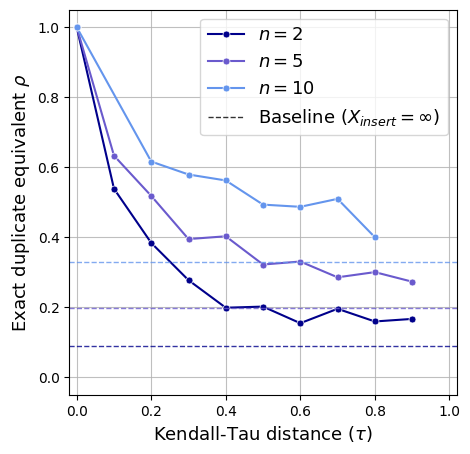

In [ ]:
import matplotlib.pyplot as plt

# get the data for baselines
with open("SOME_DATA_DIR/results_n_gram_scrambled.pickle", "rb") as f:
    all_scrambled_results = pickle.load(f)

mia = 'ratio'
colors = ['darkblue', 'slateblue', 'cornflowerblue']
plt.figure(figsize = (5, 5))
for i, ngram in enumerate((2,5,10)):
    kendall_values = ngram_to_kendal_vals[ngram]
    key = f'ngram{ngram}_kendall%d'

    n_eqs_to_plot = dict()
    for n in kendall_values:
        # print(n,key, key % n)
        n_eqs_to_plot[n] = [compute_rho(phi_fuz=auc, phi_exact=all_phi_exact[mia]) for auc in ngram_aucs[key % n][mia]] 
    plt.plot([0] + kendall_values,  [1] + [np.mean(n_eqs_to_plot[n]) for n in kendall_values], '-o', color=colors[i], markersize=5,
             markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label=rf"$n={ngram}$")
    
    # get the baseline too as a horizontal line
    baseline = compute_rho(phi_fuz=np.mean(all_scrambled_results[ngram][mia]), phi_exact=all_phi_exact[mia]) 
    plt.axhline(y=baseline, color=colors[i], linestyle='--', alpha=0.8, linewidth=1)
    
# add rthe legend for baseline
plt.axhline(y=2.0, color='black', linestyle='--', alpha=0.8, linewidth=1, label = f"Baseline ($X_{{insert}}=\infty$)")

plt.xlabel(r'Kendall-Tau distance ($\tau$)', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(loc='upper right', fontsize=13)
plt.xticks([0, 2, 4, 6, 8, 10], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(alpha = 0.8, which='both', axis='both')
plt.xlim(-0.2, 10.2)
plt.ylim(-0.05, 1.05)
#plt.savefig('/data/igor/canary/near_duplicate_experiment_neurips/figures/kendall.pdf', bbox_inches='tight')
plt.show()